# 2024/08/01

In [3]:
from lib.Gridworld import Gridworld

''' 
    game mode
    static = gridworld 위의 모든 객체(플레이어, 장애물, 함정, 도착점)의 위치가 고정,
    player = static 모드와 같으나 플레이어의 위치가 무작위로 설정됨,
    random = gridworld 위의 모든 객체(플레이어, 장애물, 함정, 도착점)의 위치가 무작위로 설정
'''
game = Gridworld(size=4, mode="static")

In [4]:
'''
    u : up,
    d : down,
    r : right,
    l : left
'''
game.makeMove("d")
game.makeMove("d")
game.makeMove("l")
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [7]:
print(game.reward())
game.board.render_np() # 4 x 4 x 4 형태의 행렬로, 인덱스 0부터 "플레이어의 위치", "도착점의 위치", "함정의 위치", "장애물의 위치"이다

-1


array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [1]:
import numpy as np
import torch
from torch import nn
from lib.Gridworld import Gridworld
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import time

# l = layer
l1 = 64 # 64차원의 벡터를 입력으로 받는다
l2 = 150 # 첫번째 은닉층의 노드 수
l3 = 100 # 두번째 은닉층의 노드 수
l4 = 4 # 출력층의 노드 수(4차원의 실수 벡터를 반환한다)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device type :", device)
print("current device :", torch.cuda.current_device())
print("number of device :", torch.cuda.device_count())

''' 모델 구현 '''
model = nn.Sequential(
    nn.Linear(l1, l2),
    nn.ReLU(),
    nn.Linear(l2, l3),
    nn.ReLU(),
    nn.Linear(l3, l4)
).to(device)
loss_fn = nn.MSELoss()
lr = 1e-3 # 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: "u",
    1: "d",
    2: "l",
    3: "r"
}

epochs = 1000
losses = []
start = time.time()
for i in range(epochs):
    game = Gridworld(size=4, mode="static") # 4 X 4 크기의 보드 게임을 사용한다

    ''' 초기 상태 처리 '''
    # 4 X 4 X 4 형태의 벡터를 1 X 64 형태의 벡터로 평활화한다
    state_ = game.board.render_np().reshape(1, 64) \
            + np.random.rand(1, 64) / 10.0 # ReLU() 함수의 0이하의 값은 모두 0으로 사상하는 특성으로 인한 "dead neuron" 현상을 막기위해 잡음을 추가한다
    state = torch.tensor(state_, dtype=torch.float, device=device)

    ''' 게임 진행 '''
    status = 1 # 게임 종료 여부; 1 = 진행중 / 0 = 종료
    while(status == 1):
        qval = model(state) # Q 값으로 구성된 벡터 출력
        # qval_ = qval.data.numpy()

        ''' 행동(동작) 선택 및 실행 '''
        if(random.random() < epsilon): # 탐험(exploration)
            action_ = np.random.randint(0, 4) # 무작위로 행동을 선택한다
        else: # 활용(exploitation)
            action_ = torch.argmax(qval, dim=1).item() # 가장 큰 Q 값을 가진 행동을 선택한다
        action = action_set[action_]
        game.makeMove(action)

        ''' 다음 상태(S_t+1)와 보상(R_t+1) '''
        state2_ = game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state2 = torch.tensor(state2_, dtype=torch.float, device=device)
        reward = torch.tensor(game.reward(), dtype=torch.float, device=device) # reward는 int형(텐서가 아니다) 객체이다
        
        ''' max Q 계산 및 Q-러닝의 label(목표값, 실제값) 항 계산 '''
        # 다음 상태(S_t+1)가 아닌 현재 상태(S_t)에 대해 모델을 학습시키는 것이므로,
        # 계산 그래프에서 다음 상태에 대한 Q 값 계산을 제외시킨다
        with torch.no_grad():
            newQ = model(state2)
        maxQ = torch.max(newQ)
        if reward == -1: # 다음 상태가 존재할 경우(게임(에피소드)이 아직 끝나지 않음)
            Y = reward + (gamma * maxQ)
        else: # 다음 상태가 더 이상 없을 경우(게임(에피소드)이 종료됨)
            Y = reward
            status = 0 # 게임이 종료되었으므로 while문을 종료한다
        # print("Y :", Y, type(Y), Y.dtype, Y.size())
        # Y는 크기가 1인 (스칼라)텐서이므로 1차원 텐서로 만들어준다
        Y = Y.unsqueeze(dim=0).detach() # 계산 그래프에서 제외시킨다
        # print("Y2 :", Y, type(Y), Y.dtype, Y.size())

        ''' Q-러닝 수행 '''
        # qval은 1 X 4 형태의 텐서이고 squeeze()를 수행하면 크기가 4인 (배열과 같은)텐서가 된다
        X = qval.squeeze()[action_].unsqueeze(dim=0) # Q 값에서 현재 취한 행동에 대한 행동 가치를 반환한다
        # print("X :", X, X.dtype, X.shape)
        loss = loss_fn(X, Y)
        loss_ = loss.item()
        losses.append(loss_)
        print(i, loss_)
        clear_output(wait=True) # 옆의 코드를 사용하면 쥬피터 셀의 실행 결과가 밑으로 계속 나열되지 않고 갱신이 이루어진다
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ''' 상태 갱신(S_t ==> S_t+1) '''
        state1 = state2

    ''' epsilon 갱신 '''
    if epsilon > 0.1:
        epsilon -= (1 / epochs)
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'Loss')

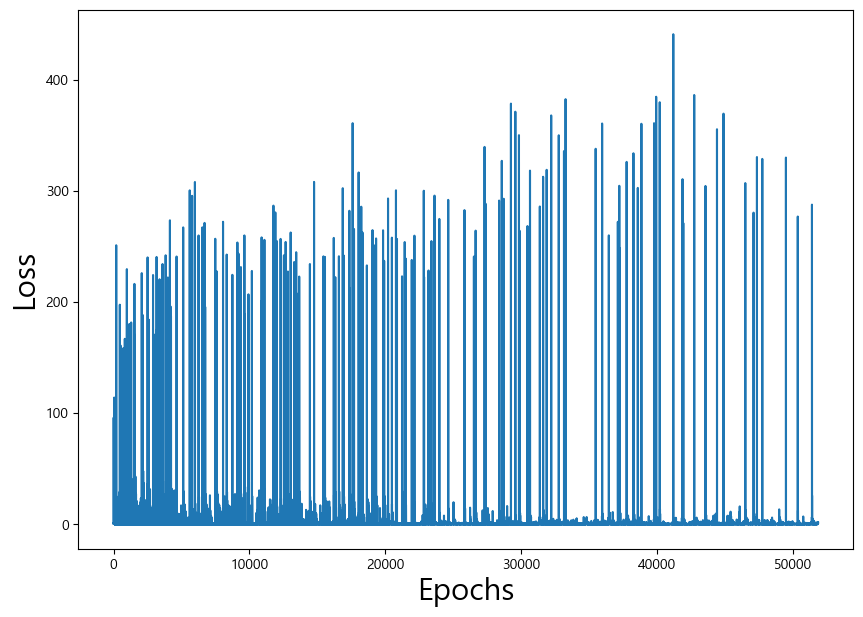

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)

In [45]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

epochs = 1000
losses = [] #A
start = time.time()
for i in range(epochs): #B
    game = Gridworld(size=4, mode='static') #C
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 #D
    state = torch.from_numpy(state_).float() #E
    status = 1 #F
    while(status == 1): #G
        qval = model(state) #H
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #I
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_] #J
        game.makeMove(action) #K
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #L
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #M
        if reward == -1: #N
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #O
        loss = loss_fn(X, Y) #P
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #Q
            status = 0
    if epsilon > 0.1: #R
        epsilon -= (1/epochs)
end = time.time()
print(f"running time : {(end - start) / 60:.3f} min")

running time : 3.875 min


Text(0, 0.5, 'Loss')

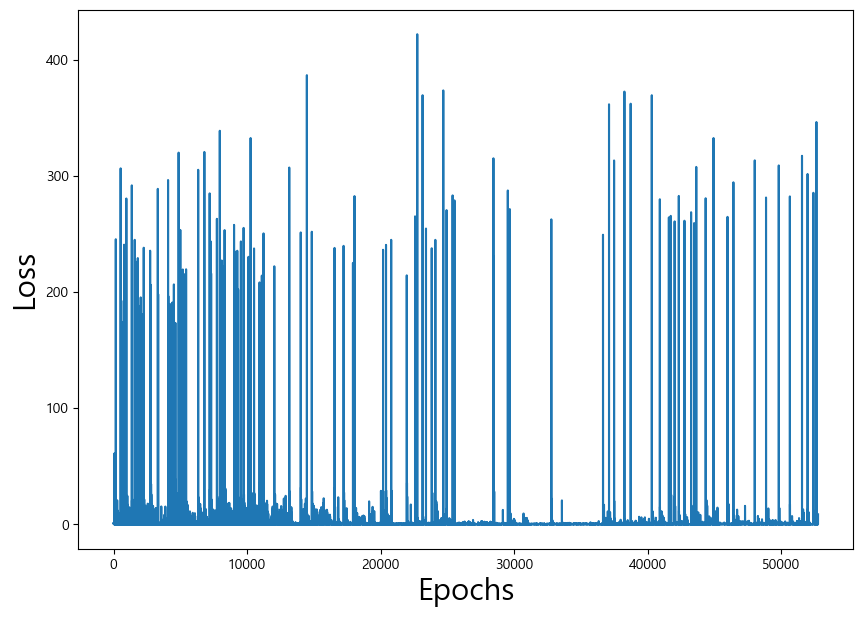

In [46]:
plt.figure(figsize=(10, 7))
plt.plot(losses)
plt.xlabel("Epochs", fontsize=22)
plt.ylabel("Loss", fontsize=22)